In [1]:
import os

import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Assemble all JSON files into a single dataframe
jsonDirectory = os.path.join('..','measurements','20241221-182340270')

jsonData = []
for filename in os.listdir(jsonDirectory):
    if not filename.endswith('.json'):
        continue
    filePath = os.path.join(jsonDirectory, filename)
    if not os.path.isfile(filePath):
        continue

    with open(filePath, 'r', encoding="utf-8") as file:
        data = json.load(file)
        jsonData.append(data)

# Now jsonData is a list of records.

In [3]:
# Create a single Pandas dataframe from the list of records.
def createDataframe(inputLengthInCharacters, kernelKey, kernelRec, timesKey):
    n = len(kernelRec[timesKey])
    return pd.DataFrame({
        'inputLengthInCharacters': [inputLengthInCharacters] * n,
        'kernel': [kernelKey] * n,
        'itemMeasured': [timesKey] * n,
        'time': kernelRec[timesKey],
    })

dfs = []
for rec in jsonData:
    inputLengthInCharacters = rec['inputLengthInCharacters']
    for k in rec['measurements'].keys():
        for kk in ['timesTransferToDevice', 'timesExecution', 'timesTransferFromDevice']:
            dfs.append( createDataframe(inputLengthInCharacters, k, rec['measurements'][k], kk) )
df = pd.concat(dfs)

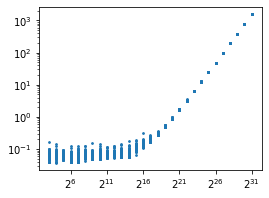

In [4]:
# Analyse execution times

dfFiltered = df[df['itemMeasured'] == 'timesExecution']
grouped = dfFiltered.groupby('kernel')

def scatterPlotForGroup(groupName):
    ddf = grouped.get_group(groupName)
    
    plt.figure(figsize=(4,3))
    plt.scatter(ddf['inputLengthInCharacters'], ddf['time'], s=3)
    plt.xscale('log', base=2)
    plt.yscale('log', base=10)
    plt.show()

scatterPlotForGroup('histogram_one_thread_per_character')

In [5]:
def statisticsForGroup(groupName):
    ddf = grouped.get_group(groupName)
    
    return ddf.groupby('inputLengthInCharacters')['time'].agg(
        average='mean',
        std_dev='std',
        min='min',
        max='max',
        first_decile=lambda x: x.quantile(0.1),
        last_decile=lambda x: x.quantile(0.9),
        median=lambda x: x.quantile(0.5)
    ).reset_index()

statistics = statisticsForGroup('histogram_one_thread_per_character')

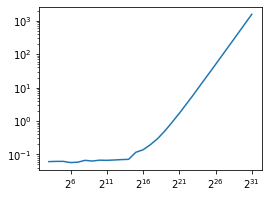

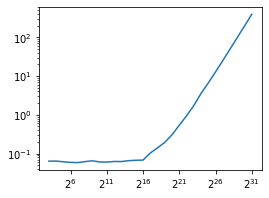

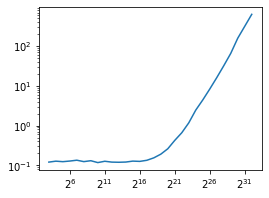

In [6]:
def lineGraphForGroup(groupName):
    statistics = statisticsForGroup(groupName)
    
    plt.figure(figsize=(4,3))
    plt.plot(statistics['inputLengthInCharacters'], statistics['average'])
    plt.xscale('log', base=2)
    plt.yscale('log', base=10)
    plt.show()

lineGraphForGroup('histogram_one_thread_per_character')
lineGraphForGroup('histogram_atomic_private')
lineGraphForGroup('histogram_atomic_private_stride')

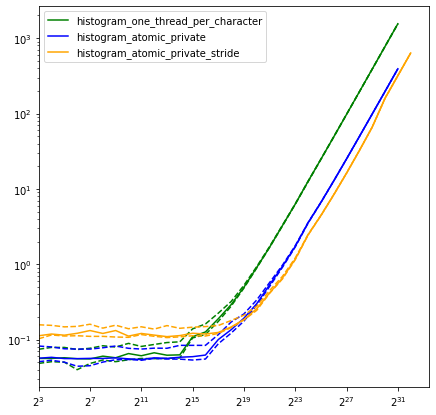

In [7]:
def lineGraphForAll():
    kernelNames = ['histogram_one_thread_per_character', 'histogram_atomic_private', 'histogram_atomic_private_stride']
    col = {
        'histogram_one_thread_per_character': 'green',
        'histogram_atomic_private': 'blue',
        'histogram_atomic_private_stride': 'orange'
    }
    s = {}
    for k in kernelNames:
        s[k] = statisticsForGroup(k)

    plt.figure(figsize=(7,7))
    for k in kernelNames:
        plt.plot(s[k]['inputLengthInCharacters'], s[k]['last_decile'], color=col[k], linestyle='--')
        plt.plot(s[k]['inputLengthInCharacters'], s[k]['median'], label=k, color=col[k])
        plt.plot(s[k]['inputLengthInCharacters'], s[k]['first_decile'], color=col[k], linestyle='--')
    plt.xscale('log', base=2)
    plt.yscale('log', base=10)
    plt.xlim(2 ** 3)
    plt.legend()
    plt.show()

lineGraphForAll()

In [8]:
df[(df['kernel'] == 'histogram_atomic_private') * (df['inputLengthInCharacters'] == 2**22) * (df['itemMeasured'] == 'timesExecution')]

,inputLengthInCharacters,kernel,itemMeasured,time
0,4194304,histogram_atomic_private,timesExecution,0.957664
1,4194304,histogram_atomic_private,timesExecution,0.968896
2,4194304,histogram_atomic_private,timesExecution,0.923168
3,4194304,histogram_atomic_private,timesExecution,0.977760
4,4194304,histogram_atomic_private,timesExecution,0.908608
...,...,...,...,...
95,4194304,histogram_atomic_private,timesExecution,0.921088
96,4194304,histogram_atomic_private,timesExecution,1.007264
97,4194304,histogram_atomic_private,timesExecution,0.917408
98,4194304,histogram_atomic_private,timesExecution,0.907616


In [9]:
df

,inputLengthInCharacters,kernel,itemMeasured,time
0,8,histogram_one_thread_per_character,timesTransferToDevice,0.076672
1,8,histogram_one_thread_per_character,timesTransferToDevice,0.030272
2,8,histogram_one_thread_per_character,timesTransferToDevice,0.032832
3,8,histogram_one_thread_per_character,timesTransferToDevice,0.028160
4,8,histogram_one_thread_per_character,timesTransferToDevice,0.029824
...,...,...,...,...
95,4294967296,histogram_atomic_private_stride,timesTransferFromDevice,0.087232
96,4294967296,histogram_atomic_private_stride,timesTransferFromDevice,0.074496
97,4294967296,histogram_atomic_private_stride,timesTransferFromDevice,0.083296
98,4294967296,histogram_atomic_private_stride,timesTransferFromDevice,0.074624
